## Transfer learning test - scoping out SEDE data

### Step 0: importation of stuff

In [1]:
library(tidyverse)
library(data.table)
library(distr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: startupmsg

Utilities for Start-Up Messages (version 0.9.6)

For more information see ?"startupmsg", NEWS("startupmsg")


Loading required package: sfsm

### Step 1: Exploring the data

In [2]:
# make a dataframe for each set of comments stratified by programming language
df_c = read_csv("data/sede_c_4_06.csv")
df_cplusplus = read_csv("data/sede_c++_4_06.csv")
df_java = read_csv("data/sede_java_4_06.csv")
df_javascript = read_csv("data/sede_javascript_4_06.csv")
df_python = read_csv("data/sede_python_4_06.csv")

raw_df = rbind(df_c, df_cplusplus, df_java, df_javascript, df_python)

Rows: 50000 Columns: 8

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Tags
dbl  (6): Id, PostId, Score, UserId, ViewCount, AnswerCount
dttm (1): CreationDate


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 50000 Columns: 8

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Tags
dbl  (6): Id, PostId, Score, UserId, ViewCount, AnswerCount
dttm (1): CreationDate


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Ro

In [3]:
# get a summary of some characteristics of raw df

raw_df = mutate(raw_df, Score = as.integer(Score), ViewCount = as.integer(ViewCount), AnswerCount = as.integer(AnswerCount))

In [4]:
head(raw_df)

Id,PostId,Score,CreationDate,UserId,Tags,ViewCount,AnswerCount
<dbl>,<dbl>,<int>,<dttm>,<dbl>,<chr>,<int>,<int>
121180438,1642028,75,2021-07-29 00:16:35,204555,<c><operators><code-formatting><standards-compliance>,907070,29
121254102,68610799,33,2021-08-01 13:24:00,10871073,<c><pointers><void-pointers>,4721,5
125693332,71105071,25,2022-02-13 21:54:18,7733418,<c><c-preprocessor>,7723,3
124197573,70258418,24,2021-12-07 10:32:26,898348,<c++><c><exception><segmentation-fault>,9923,16
122235660,69159968,24,2021-09-13 09:02:26,2878796,<c++><c><struct><declaration><typedef>,3596,8
122248825,69167256,16,2021-09-13 18:07:22,10077,<c><pointers>,103,2


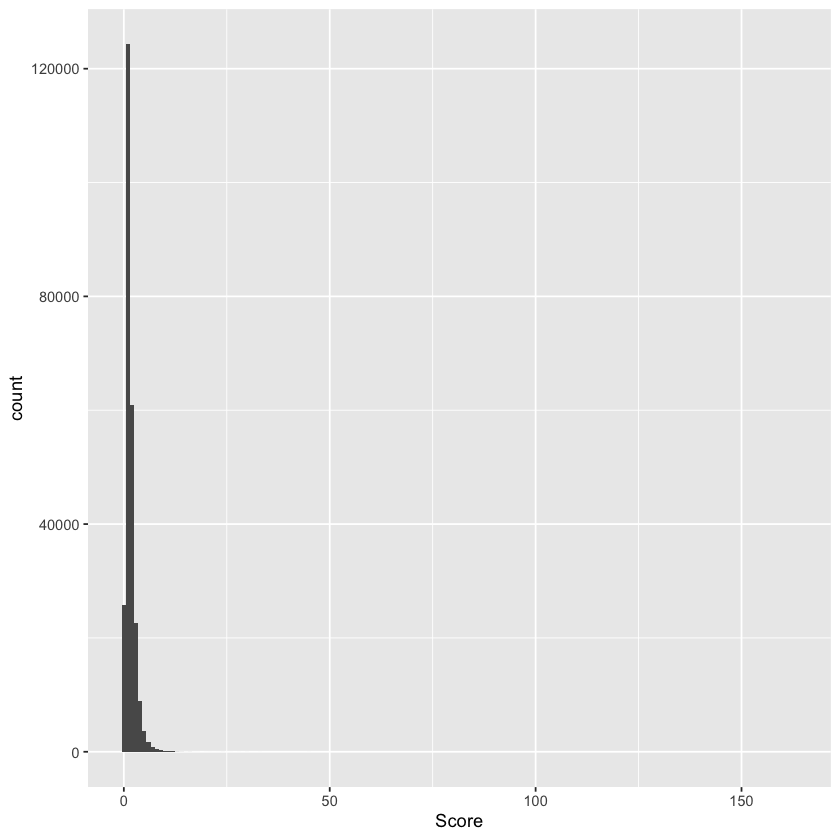

In [5]:
ggplot(raw_df, aes(x=Score)) + geom_histogram(binwidth=1)

In [6]:
count_df = raw_df %>% count(UserId) %>% arrange(desc(n))

# print counts of the count df here rather than make a histogram because of extreme right skew
head(count_df)
print(nrow(filter(count_df, n==1)))
print(nrow(filter(count_df, n==2)))
print(nrow(filter(count_df, n==3)))

UserId,n
<dbl>,<int>
1491895,3772
440558,3135
3003365,1632
4117728,1527
4581301,1521
4142924,1385


[1] 20140
[1] 4979
[1] 2188


In [7]:
nrow(filter(count_df, n >= 20))

[1] 1466

In [8]:
# is there a more time-efficient way to generate all tags?

tags = c('python', 'java', 'javascript', 'c', 'c++')

In [9]:
tags_df = data.frame(matrix(ncol=2,nrow=0))
for (i in c(1:length(tags))) {
    occurrences = nrow(filter(raw_df, grepl(paste("<",tags[i],">",sep=""), raw_df$Tags, fixed=TRUE)))
    tags_df= rbind(tags_df, c(tags[i], occurrences))
}
colnames(tags_df) <- c('tag', 'occurrences')

In [10]:
tags_df$occurrences <- as.numeric(tags_df$occurrences)

In [11]:
head(arrange(tags_df, desc(occurrences)), 10)

,tag,occurrences
,<chr>,<dbl>
1,c++,53760
2,c,52208
3,python,51527
4,javascript,50699
5,java,50507


## Step 2: Filter out the data into in-sample and out-of-sample, using select tags

In [12]:
python_df = filter(raw_df, grepl("<python>", raw_df$Tags, fixed=TRUE))
cplusplus_df = filter(raw_df, grepl("<c++>", raw_df$Tags, fixed=TRUE))
javascript_df = filter(raw_df, grepl("<javascript>", raw_df$Tags, fixed=TRUE))
c_df = filter(raw_df, grepl("<c>", raw_df$Tags, fixed=TRUE))
java_df = filter(raw_df, grepl("<java>", raw_df$Tags, fixed=TRUE))

In [13]:
python_counts = python_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>=20)
cplusplus_counts = cplusplus_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>=20)
javascript_counts = javascript_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>=20)
c_counts = c_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>=20)
java_counts = java_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>=20)

In [14]:
python_df = merge(python_counts, python_df, by="UserId")
cplusplus_df = merge(cplusplus_counts, cplusplus_df, by="UserId")
javascript_df = merge(javascript_counts, javascript_df, by="UserId")
c_df = merge(c_counts, c_df, by="UserId")
java_df = merge(java_counts, java_df, by="UserId")

In [15]:
set.seed(1729)

TRAIN_TEST_SPLIT = 0.7

in_sample_python = sample(unique(python_df$UserId), size = TRAIN_TEST_SPLIT*length(unique(python_df$UserId)))
python_df.in = filter(python_df, UserId %in% in_sample_python)
python_df.out = filter(python_df, !UserId %in% in_sample_python)

in_sample_cplusplus = sample(unique(cplusplus_df$UserId), size = TRAIN_TEST_SPLIT*length(unique(cplusplus_df$UserId)))
cplusplus_df.in = filter(cplusplus_df, UserId %in% in_sample_cplusplus)
cplusplus_df.out = filter(cplusplus_df, !UserId %in% in_sample_cplusplus)

in_sample_javascript = sample(unique(javascript_df$UserId), size = TRAIN_TEST_SPLIT*length(unique(javascript_df$UserId)))
javascript_df.in = filter(javascript_df, UserId %in% in_sample_javascript)
javascript_df.out = filter(javascript_df, !UserId %in% in_sample_javascript)

in_sample_c = sample(unique(c_df$UserId), size = TRAIN_TEST_SPLIT*length(unique(c_df$UserId)))
c_df.in = filter(c_df, UserId %in% in_sample_c)
c_df.out = filter(c_df, !UserId %in% in_sample_c)

in_sample_java = sample(unique(java_df$UserId), size = TRAIN_TEST_SPLIT*length(unique(java_df$UserId)))
java_df.in = filter(java_df, UserId %in% in_sample_java)
java_df.out = filter(java_df, !UserId %in% in_sample_java)

## Step 3: Train the EB Model

We'll be using a Poisson DGP with a Gamma prior, assuming all comments had the same window to accumulate points.

In [16]:
# possible settings are 'time', 'views', and 'none'
EXPOSURE_MODEL = 'views'

In [17]:
in_sample_data <- list(python_in = python_df.in,
                       cplusplus_in = cplusplus_df.in,
                       javascript_in = javascript_df.in,
                       c_in = c_df.in,
                       java_in = java_df.in)

in_sample_names = c("python_in", "cplusplus_in", "javascript_in", "c_in", "java_in")
ds_creation_date = "04/06/2022 00:18:00"
ds_creation_date <- as.POSIXct(ds_creation_date,format="%m/%d/%Y %H:%M:%S",tz="UTC")

In [18]:
priors_df <- data.frame(matrix(ncol=3,nrow=0))

# list containing all the prior dfs
prior_df_set <- list(python_in = 0, cplusplus_in = 0, javascript_in = 0, c_in = 0, java_in = 0)

for (i in c(1:5)) {
    prior_df <- in_sample_data[[in_sample_names[i]]]
    if (EXPOSURE_MODEL == 'time') {
        prior_df <- mutate(prior_df, timePassed = as.numeric(ds_creation_date - CreationDate)/365)
        prior_df <- group_by(prior_df, UserId) %>% summarize(avgScore = sum(Score)/sum(timePassed))
    } else if (EXPOSURE_MODEL == 'views') {
        prior_df <- group_by(prior_df, UserId) %>% summarize(avgScore = sum(Score)/sum(ViewCount))
    } else {
        prior_df <- group_by(prior_df, UserId) %>% summarize(avgScore = mean(Score))
    }
    
    name <- in_sample_names[i]
    
    # alpha calculation derived from wikipedia - look more into theory here
    s <- log(mean(prior_df$avgScore)) - mean(log(prior_df$avgScore))
    alpha_est <- (3 - s + sqrt((s-3)^2 + 24 * s))/(12*s)
    
    # newton-raphson update
    for (i in c(1:200)) {
        alpha_est <- alpha_est - (log(alpha_est) - digamma(alpha_est) - s)/(1/alpha_est - trigamma(alpha_est))
    }
    
    beta_est <- 1/(mean(prior_df$avgScore)/alpha_est)
    
    priors_df <- rbind(priors_df, c(name, alpha_est, beta_est))
    
    prior_df_set[[name]] <- prior_df
    
}
colnames(priors_df) <- c('name', 'alpha', 'beta')
priors_df$alpha <- as.numeric(priors_df$alpha)
priors_df$beta <- as.numeric(priors_df$beta)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



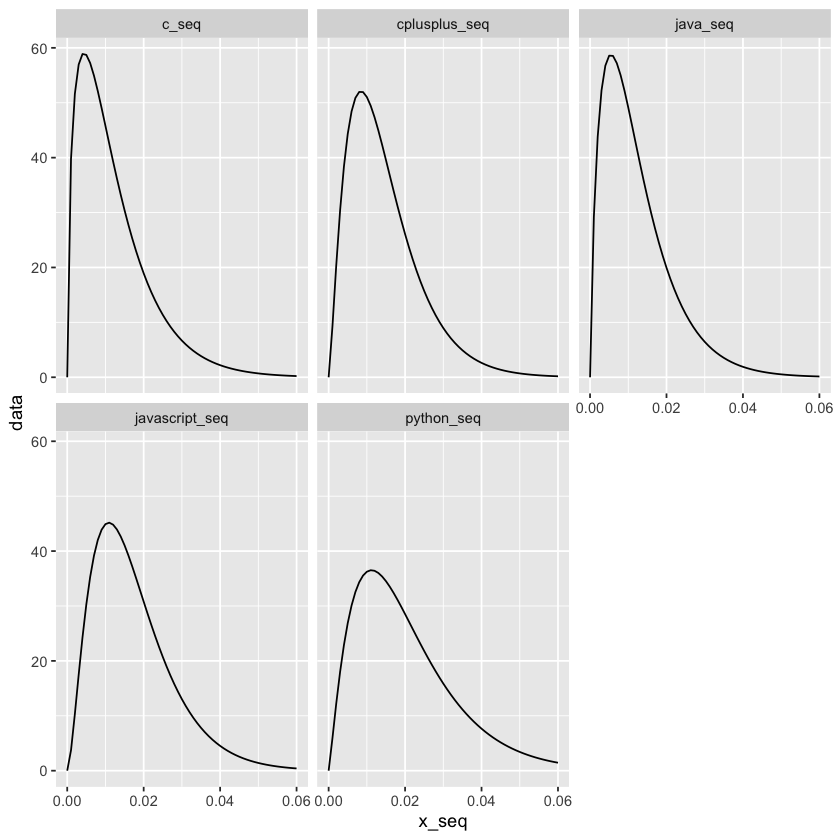

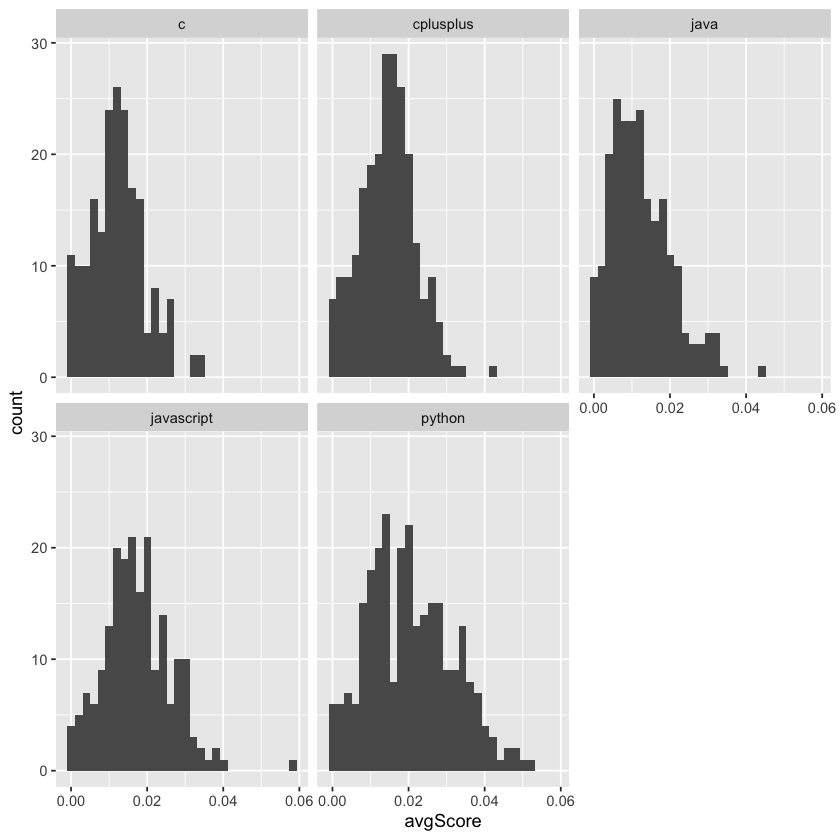

In [19]:
x_seq = seq(0, 0.06, by = 0.001)
python_seq = dgamma(x_seq, shape = priors_df$alpha[1], rate = priors_df$beta[1])
cplusplus_seq = dgamma(x_seq, shape = priors_df$alpha[2], rate = priors_df$beta[2])
javascript_seq = dgamma(x_seq, shape = priors_df$alpha[3], rate = priors_df$beta[3])
c_seq = dgamma(x_seq, shape = priors_df$alpha[4], rate = priors_df$beta[4])
java_seq = dgamma(x_seq, shape = priors_df$alpha[5], rate = priors_df$beta[5])

seq_df = rbind(tibble(x_seq, data = python_seq, type='python_seq'),
               tibble(x_seq, data = cplusplus_seq, type='cplusplus_seq'),
               tibble(x_seq, data = javascript_seq, type='javascript_seq'),
               tibble(x_seq, data = c_seq, type='c_seq'),
               tibble(x_seq, data = java_seq, type='java_seq'))

ggplot(seq_df) + geom_line(aes(x=x_seq, y=data)) + facet_wrap(vars(type))

orig_avg_df <- rbind(tibble(prior_df_set[['python_in']], type = 'python'),
                     tibble(prior_df_set[['cplusplus_in']], type = 'cplusplus'),
                     tibble(prior_df_set[['javascript_in']], type = 'javascript'),
                     tibble(prior_df_set[['c_in']], type = 'c'),
                     tibble(prior_df_set[['java_in']], type = 'java'))

ggplot(orig_avg_df) + geom_histogram(aes(x=avgScore)) + facet_wrap(vars(type))

In [20]:
priors_df

name,alpha,beta
<chr>,<dbl>,<dbl>
python_in,2.206502,107.5899
cplusplus_in,2.375168,162.4999
javascript_in,2.679182,154.1242
c_in,1.555460,126.7823
java_in,1.791023,144.9123


## Step 4: Test performance on test set

In [21]:
out_sample_data <- list(python_out = python_df.out,
                       cplusplus_out = cplusplus_df.out,
                       javascript_out = javascript_df.out,
                       c_out = c_df.out,
                       java_out = java_df.out)

out_sample_names = c("python_out", "cplusplus_out", "javascript_out", "c_out", "java_out")

In [22]:
out_sample_subset <- list(python_out = python_df.out,
                       cplusplus_out = cplusplus_df.out,
                       javascript_out = javascript_df.out,
                       c_out = c_df.out,
                       java_out = java_df.out)
# this dataset contains what we'll evaluate on
out_sample_train <- list(python_out = 0, cplusplus_out = 0, javascript_out = 0, c_out = 0, java_out = 0)
# this dataset contains what we consider to be "ground truth"
out_sample_test <- list(python_out = 0, cplusplus_out = 0, javascript_out = 0, c_out = 0, java_out = 0)

In [23]:
SLICE_SIZE = 20

for (i in c(1:5)) {
    temp <- filter(out_sample_subset[[i]], n >= SLICE_SIZE) %>%
      group_by(UserId) %>% 
      arrange(CreationDate, .by_group = TRUE) %>%
      slice_head(n=SLICE_SIZE)
    out_sample_subset[[i]] = temp
    out_sample_train[[i]] = group_by(temp, UserId) %>% 
      arrange(CreationDate, .by_group = TRUE) %>%
      slice_head(n=SLICE_SIZE / 2)
    out_sample_test[[i]] = group_by(temp, UserId) %>% 
      arrange(CreationDate, .by_group = TRUE) %>%
      slice_tail(n=SLICE_SIZE / 2)
    
    # let's take a look at the size of the test sets we are using - divide #rows by slice number to get # of users in each set
    print(out_sample_subset[i])

}

$python_out
# A tibble: 2,320 × 9
# Groups:   UserId [116]
   UserId     n        Id   PostId Score CreationDate        Tags      ViewCount
    <dbl> <int>     <dbl>    <dbl> <int> <dttm>              <chr>         <int>
 1   7432   166 118394732 66978173     2 2021-04-07 03:28:41 <python>…        86
 2   7432   166 118423199 66995585     1 2021-04-08 00:05:56 <python>…        67
 3   7432   166 118445726 67008431     1 2021-04-08 17:01:23 <python>…       334
 4   7432   166 118543188 67064899     1 2021-04-12 19:58:19 <python>…        27
 5   7432   166 118543613 67065124     2 2021-04-12 20:17:36 <python>…        43
 6   7432   166 118622764 67109822     1 2021-04-15 14:08:38 <python>…        17
 7   7432   166 118634741 67116573     3 2021-04-15 22:13:24 <python>…       215
 8   7432   166 118681196 67142326     3 2021-04-17 21:10:16 <python>…        12
 9   7432   166 118719926 67164150     1 2021-04-19 15:22:19 <python>…       315
10   7432   166 118729149 67169632     1 2021-04-1

In [24]:
results_df <- data.frame(matrix(ncol=6,nrow=0))

for (i in c(1:5)) {
    for (j in c(1:SLICE_SIZE/2)) {
        out_sample <- out_sample_train[[out_sample_names[i]]]
        out_sample <- group_by(out_sample, UserId) %>% 
                      arrange(CreationDate, .by_group = TRUE) %>%
                      slice_head(n=j)
        
        if (EXPOSURE_MODEL == 'time') {
            avg_df <- out_sample_test[[out_sample_names[i]]] %>% 
                group_by(UserId) %>% 
                mutate(Time=as.numeric(ds_creation_date - CreationDate)/365) %>% 
                summarize(avgScore = sum(Score)/sum(Time))
        } else if (EXPOSURE_MODEL == 'views') {
            avg_df <- out_sample_test[[out_sample_names[i]]] %>% group_by(UserId) %>% 
                summarize(avgScore = sum(Score)/sum(ViewCount))
        } else {
            avg_df <- out_sample_test[[out_sample_names[i]]] %>% group_by(UserId) %>% summarize(avgScore = mean(Score))
        }
        
        out_sample <- merge(out_sample, avg_df, by="UserId")
        alpha <- drop(priors_df[i,]$alpha)
        beta <- drop(priors_df[i,]$beta)
    
        for (id in unique(out_sample$UserId)) {
            user_out_sample <- filter(out_sample, UserId==id)
            user_out_sample <- mutate(user_out_sample,Time=as.numeric(ds_creation_date - CreationDate)/365)
            avg_score <- drop(user_out_sample$avgScore[1])
            
            if (EXPOSURE_MODEL == 'time') {
                user_alpha <- alpha + sum(user_out_sample$Score)
                user_beta <- beta + sum(user_out_sample$Time)                
            } else if (EXPOSURE_MODEL == 'views') {
                user_alpha <- alpha + sum(user_out_sample$Score)
                user_beta <- beta + sum(user_out_sample$ViewCount)
            } else {
                user_alpha <- alpha + sum(user_out_sample$Score)
                user_beta <- beta + nrow(user_out_sample)                
            }

            theta_b <- (user_alpha - 1)/user_beta # MAP estimate
            
            if (EXPOSURE_MODEL == 'time') {
                theta_f <- sum(user_out_sample$Score)/sum(user_out_sample$Time)              
            } else if (EXPOSURE_MODEL == 'views') {
                theta_f <- sum(user_out_sample$Score)/sum(user_out_sample$ViewCount)
            } else {
                theta_f <- mean(user_out_sample$Score)               
            }

            to_add <- c(out_sample_names[i], id, avg_score, theta_b, 'eb', j)
            results_df <- rbind(results_df, to_add)
            to_add <- c(out_sample_names[i], id, avg_score, theta_f, 'freq', j)
            results_df <- rbind(results_df, to_add)
        }
    }
}

colnames(results_df) <- c('dataset', 'user', 'avg', 'estimated', 'method', 'num_train')

results_df$avg = as.numeric(results_df$avg)
results_df$estimated = as.numeric(results_df$estimated)
results_df$num_train = as.numeric(results_df$num_train)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



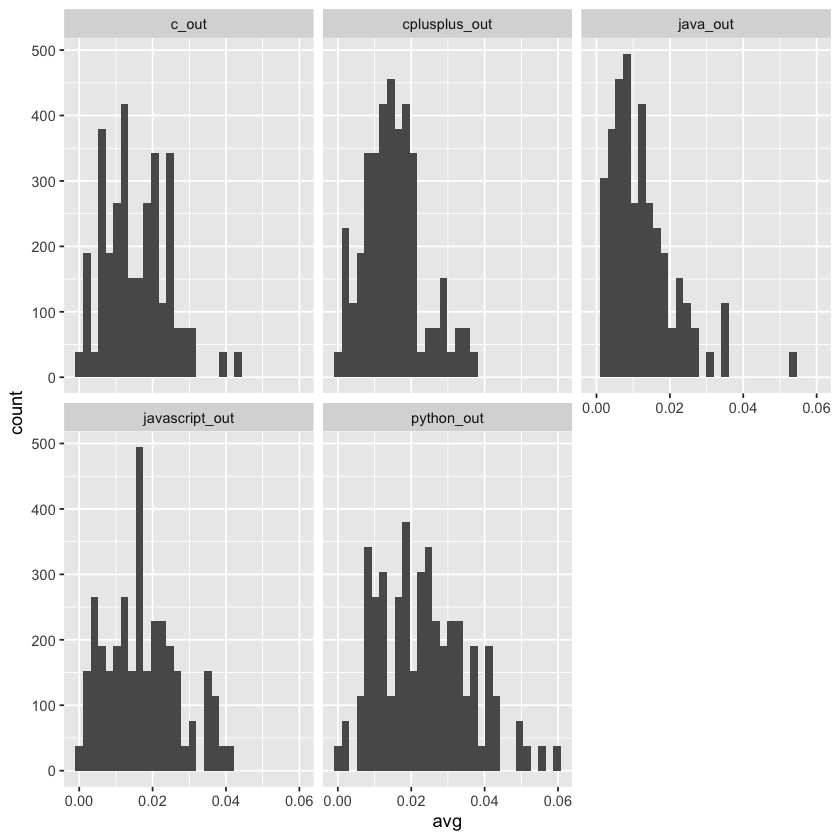

In [25]:
# distribution of average values based on the dataset they came from
ggplot(results_df) + 
    geom_histogram(aes(x=avg)) +
    facet_wrap(vars(dataset))

In [26]:
quantiles_df = data.frame(matrix(ncol=3,nrow=0))
for (ds in unique(results_df$dataset)) {
    temp = filter(results_df, dataset==ds)
    temp <- select(temp, c(dataset, user, avg))
    temp <- temp[!duplicated(temp),]
    
    # assign each user a decile based on their average score among other users in the out-sample
    buckets=quantile(temp$avg, seq(0,1,0.1), names=FALSE)
    buckets[1] = buckets[1] - 1e-6
    buckets = unique(buckets)
    
    print(buckets)
    print(ds)
    
    temp$quantile = cut(temp$avg, buckets, labels=c(1:(length(buckets)-1)))
    
    temp <- select(temp, c(user, dataset, quantile))
    temp <- temp[!duplicated(temp),]
    
    quantiles_df <- rbind(quantiles_df, temp)
}

quantiles_df$quantile = as.numeric(quantiles_df$quantile)

 [1] 4.293078e-05 8.060491e-03 1.171171e-02 1.599467e-02 1.919561e-02
 [6] 2.333013e-02 2.529960e-02 2.921747e-02 3.326810e-02 4.041951e-02
[11] 5.976096e-02
[1] "python_out"
 [1] 5.031006e-06 5.924951e-03 8.842444e-03 1.069959e-02 1.302932e-02
 [6] 1.431493e-02 1.666667e-02 1.826793e-02 2.023919e-02 2.628571e-02
[11] 3.680203e-02
[1] "cplusplus_out"
 [1] 0.0008257196 0.0037269787 0.0088446975 0.0114389920 0.0144742961
 [6] 0.0168855535 0.0184764299 0.0218823724 0.0249204052 0.0323679958
[11] 0.0407766990
[1] "javascript_out"
 [1] 0.0006963501 0.0057673671 0.0072935256 0.0105443524 0.0126645022
 [6] 0.0138356484 0.0183508119 0.0201412547 0.0234830923 0.0254813003
[11] 0.0423162584
[1] "c_out"
 [1] 0.001117068 0.003608159 0.005276552 0.006947397 0.008038951 0.010230179
 [7] 0.012897323 0.014504605 0.017989679 0.023456711 0.052738337
[1] "java_out"


In [27]:
results_df <- merge(results_df, quantiles_df, by=c('user', 'dataset'))
results_df$sq_error = (results_df$avg - results_df$estimated)^2

In [28]:
graphed_df = group_by(results_df, dataset, method, quantile, num_train) %>% summarize(mse = mean(sq_error))

`summarise()` has grouped output by 'dataset', 'method', 'quantile'. You can override using the `.groups` argument.



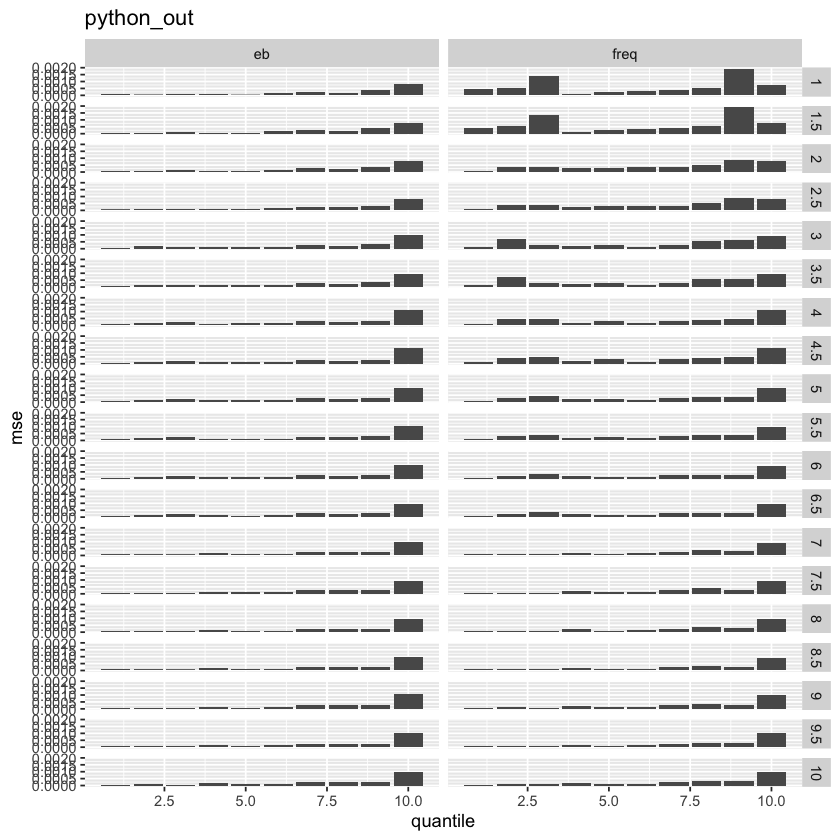

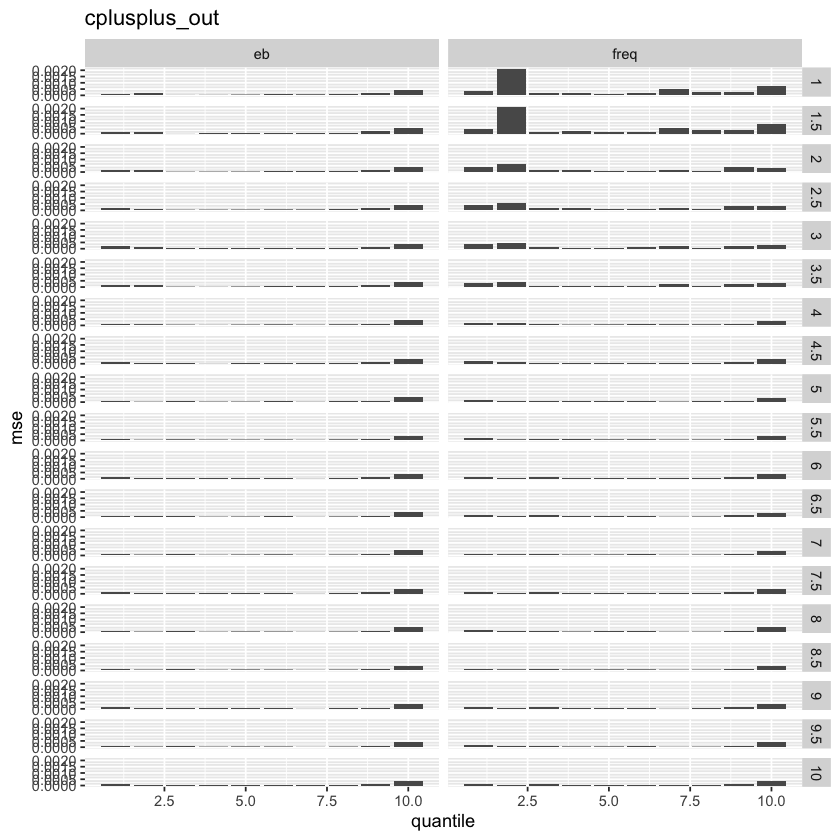

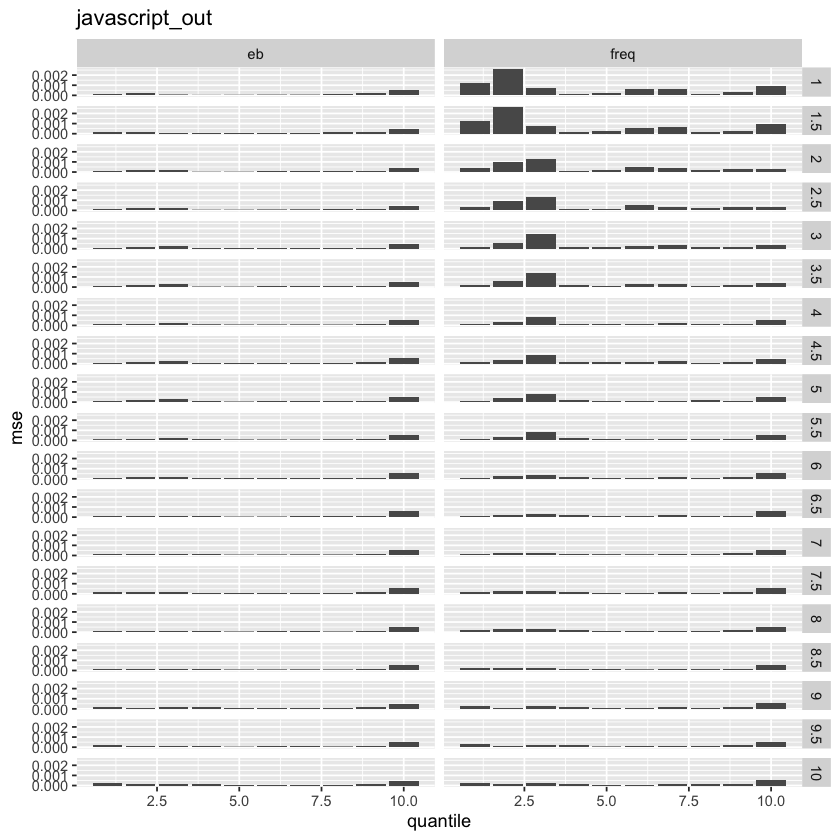

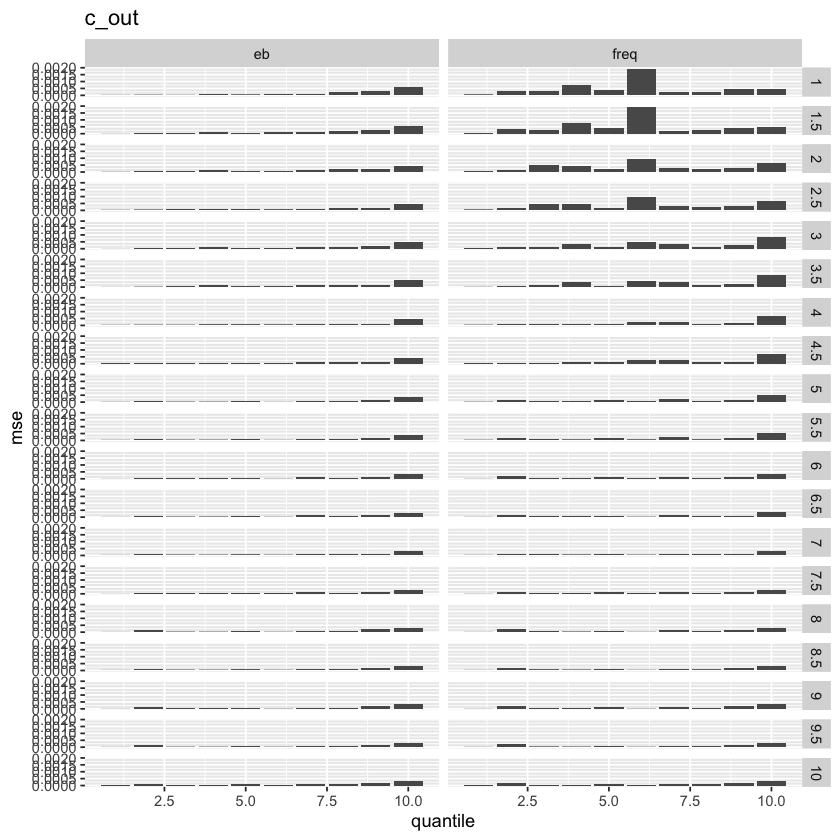

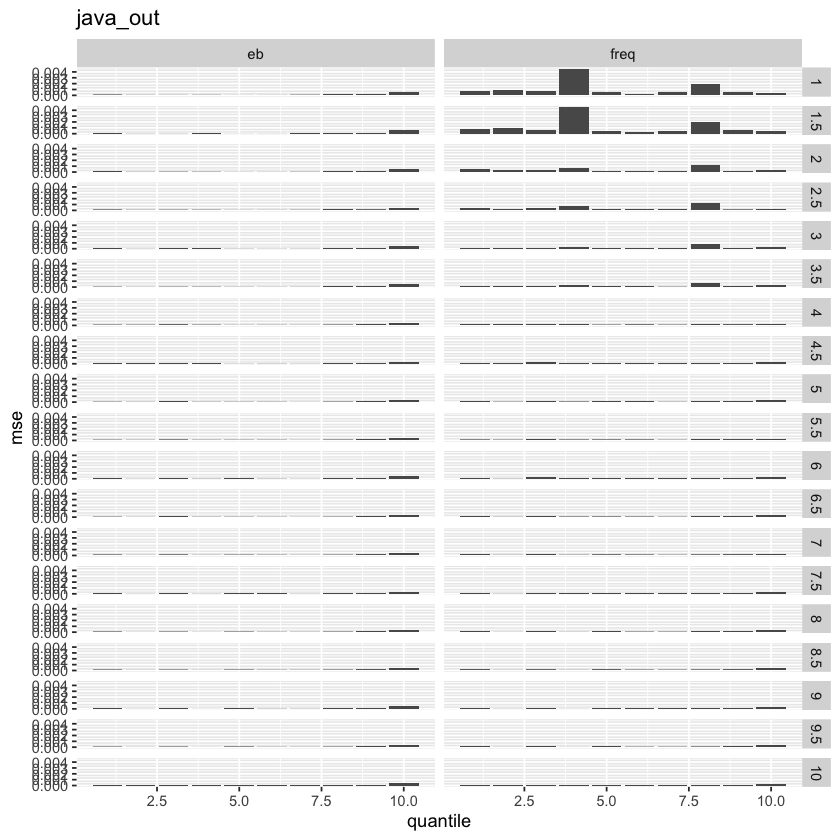

In [29]:
plots <- c(1:5)
for (i in c(1:length(out_sample_names))) {
    ds = out_sample_names[[i]]
    print(ggplot(filter(graphed_df,dataset==ds)) + 
        geom_bar(aes(x=quantile,y=mse), stat='identity') +
        facet_grid(rows = vars(num_train), cols=vars(method)) +
        scale_y_continuous(name="mse") + 
        ggtitle(ds)) 
}

`summarise()` has grouped output by 'dataset', 'method'. You can override using the `.groups` argument.



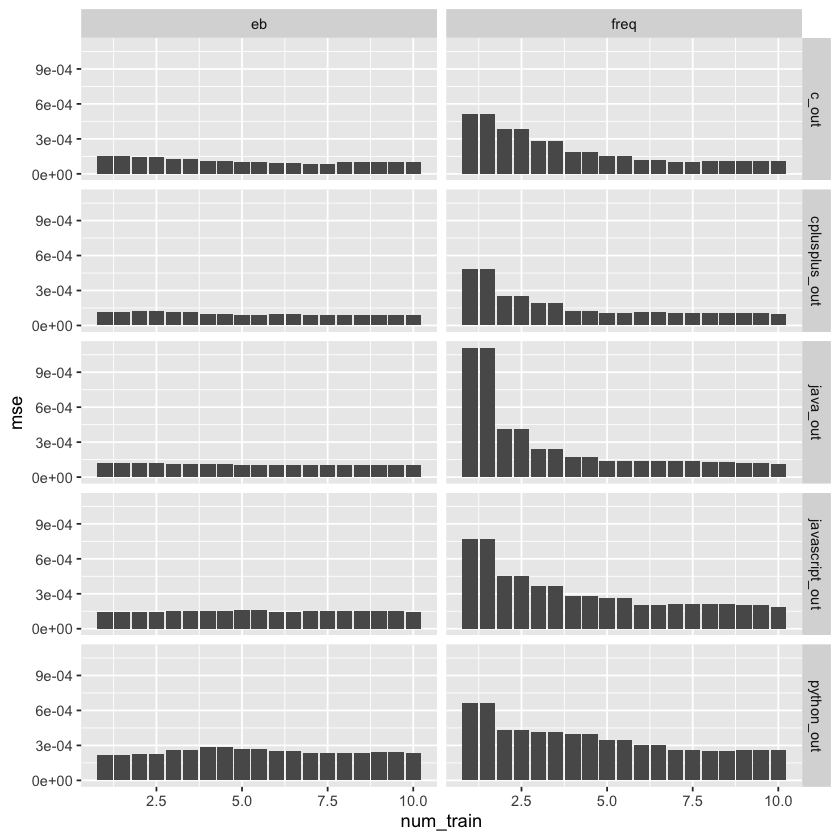

In [30]:
graphed_df = group_by(results_df, dataset, method, num_train) %>% summarize(mse = mean(sq_error))
ggplot(graphed_df) + 
       geom_bar(aes(x=num_train,y=mse), stat='identity') +
       facet_grid(rows = vars(dataset), cols=vars(method))

## Step 5: Investigate transfer between datasets

In [31]:
train_ds = filter(in_sample_data[['c_in']], UserId %in% in_sample_data[['cplusplus_in']]$UserId)
# train_ds = in_sample_data[['cplusplus_in']]
train_ds <- mutate(train_ds, timePassed = as.numeric(ds_creation_date - CreationDate)/365)

if (EXPOSURE_MODEL == 'time') {
    train_ds <- group_by(train_ds, UserId) %>% summarize(avgScore = sum(Score)/sum(timePassed))
} else if (EXPOSURE_MODEL == 'views') {
    train_ds <- group_by(train_ds, UserId) %>% summarize(avgScore = sum(Score)/sum(ViewCount))
} else {
    train_ds <- group_by(train_ds, UserId) %>% summarize(avgScore = mean(Score))
}

s <- log(mean(train_ds$avgScore)) - mean(log(train_ds$avgScore))
alpha_est <- (3 - s + sqrt((s-3)^2 + 24 * s))/(12*s)

for (i in c(1:200)) {
    alpha_est <- alpha_est - (log(alpha_est) - digamma(alpha_est) - s)/(1/alpha_est - trigamma(alpha_est))
}

beta_est <- 1/(mean(train_ds$avgScore)/alpha_est)

alpha_transfer <- alpha_est
beta_transfer <- beta_est

print(c(alpha_transfer, beta_transfer))

[1]   2.018029 143.858853


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



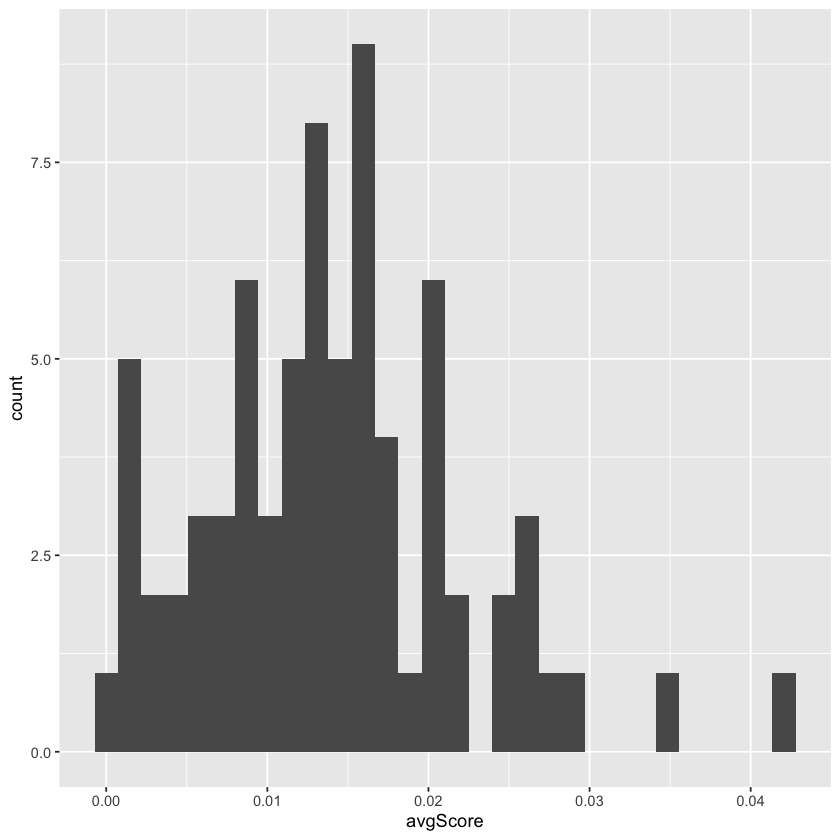

In [32]:
ggplot(train_ds) + geom_histogram(aes(x=avgScore))

In [33]:
transfer_results_df <- data.frame(matrix(ncol=6,nrow=0))

for (j in c(1:25)) {
    out_sample <- out_sample_train[['c_out']]
    out_sample <- group_by(out_sample, UserId) %>% 
                  arrange(CreationDate, .by_group = TRUE) %>%
                  slice_head(n=j)
    
    if (EXPOSURE_MODEL == 'time') {
        avg_df <- out_sample_test[['c_out']] %>% 
            group_by(UserId) %>% 
            mutate(Time=as.numeric(ds_creation_date - CreationDate)/365) %>% 
            summarize(avgScore = sum(Score)/sum(Time))
    } else if (EXPOSURE_MODEL == 'views') {
        avg_df <- out_sample_test[['c_out']] %>% group_by(UserId) %>% summarize(avgScore = sum(Score)/sum(ViewCount))
    } else {
        avg_df <- out_sample_test[['c_out']] %>% group_by(UserId) %>% summarize(avgScore = mean(Score))
    }
    
    out_sample <- merge(out_sample, avg_df, by="UserId")
    alpha_prior <- drop(filter(priors_df,name=='c_in')$alpha)
    beta_prior <- drop(filter(priors_df,name=='c_in')$beta)

    for (id in unique(out_sample$UserId)) {
        user_out_sample <- filter(out_sample, UserId==id)
        user_out_sample <- mutate(user_out_sample,Time=as.numeric(ds_creation_date - CreationDate)/365)
        avg_score <- drop(user_out_sample$avgScore[1])
        
        if (EXPOSURE_MODEL == 'time') {
            user_alpha <- alpha_transfer + sum(user_out_sample$Score)
            user_beta <- beta_transfer + sum(user_out_sample$Time)
            user_alpha_base <- alpha_prior + sum(user_out_sample$Score)
            user_beta_base <- beta_prior + sum(user_out_sample$Time)
        } else if (EXPOSURE_MODEL == 'views') {
            user_alpha <- alpha_transfer + sum(user_out_sample$Score)
            user_beta <- beta_transfer + sum(user_out_sample$ViewCount)
            user_alpha_base <- alpha_prior + sum(user_out_sample$Score)
            user_beta_base <- beta_prior + sum(user_out_sample$ViewCount)
        } else {
            user_alpha <- alpha_transfer + sum(user_out_sample$Score)
            user_beta <- beta_transfer + nrow(user_out_sample)
            user_alpha_base <- alpha_prior + sum(user_out_sample$Score)
            user_beta_base <- beta_prior + nrow(user_out_sample)
        }

        
        theta_b <- (user_alpha - 1)/user_beta # MAP estimate
        
        theta_b_base <- (user_alpha_base - 1)/user_beta_base
        
        if (EXPOSURE_MODEL == 'time') {
            theta_f <- sum(user_out_sample$Score)/sum(user_out_sample$Time)
        } else if (EXPOSURE_MODEL == 'views') {
            theta_f <- sum(user_out_sample$Score)/sum(user_out_sample$ViewCount)
        } else {
            theta_f <- mean(user_out_sample$Score)
        }        
        
        to_add <- c('c_out', id, avg_score, theta_b, 'eb_transfer', j)
        transfer_results_df <- rbind(transfer_results_df, to_add)
        to_add <- c('c_out', id, avg_score, theta_f, 'freq', j)
        transfer_results_df <- rbind(transfer_results_df, to_add)
        to_add <- c('c_out', id ,avg_score, theta_b_base, 'eb', j)
        transfer_results_df <- rbind(transfer_results_df, to_add)
    }
}

colnames(transfer_results_df) <- c('dataset', 'user', 'avg', 'estimated', 'method', 'num_train')

transfer_results_df$avg = as.numeric(transfer_results_df$avg)
transfer_results_df$estimated = as.numeric(transfer_results_df$estimated)
transfer_results_df$num_train = as.numeric(transfer_results_df$num_train)

`summarise()` has grouped output by 'dataset', 'method'. You can override using the `.groups` argument.



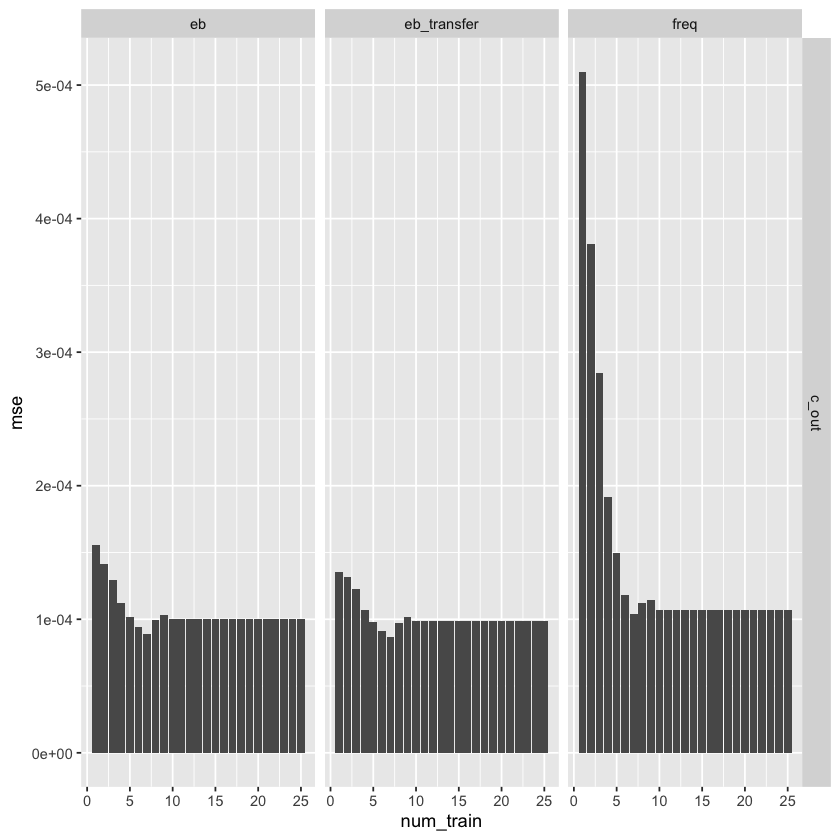

In [34]:
transfer_results_df <- merge(transfer_results_df, quantiles_df, by=c('user', 'dataset'))
transfer_results_df$sq_error = (transfer_results_df$avg - transfer_results_df$estimated)^2

graphed_df = group_by(transfer_results_df, dataset, method, num_train) %>% summarize(mse = mean(sq_error))
ggplot(graphed_df) + 
       geom_bar(aes(x=num_train,y=mse), stat='identity') +
       facet_grid(rows = vars(dataset), cols=vars(method))